
# Wavelet estimation
This example shows how to use the :py:class:`pylops.avo.prestack.PrestackWaveletModelling` to
estimate a wavelet from pre-stack seismic data. This problem can be written in mathematical
form as:

\begin{align}\mathbf{d}=  \mathbf{G} \mathbf{w}\end{align}

where $\mathbf{G}$ is an operator that convolves an angle-variant reflectivity series
with the wavelet $\mathbf{w}$ that we aim to retrieve.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import filtfilt

import pylops
from pylops.utils.wavelets import ricker

plt.close("all")
np.random.seed(0)

Let's start by creating the input elastic property profiles and wavelet



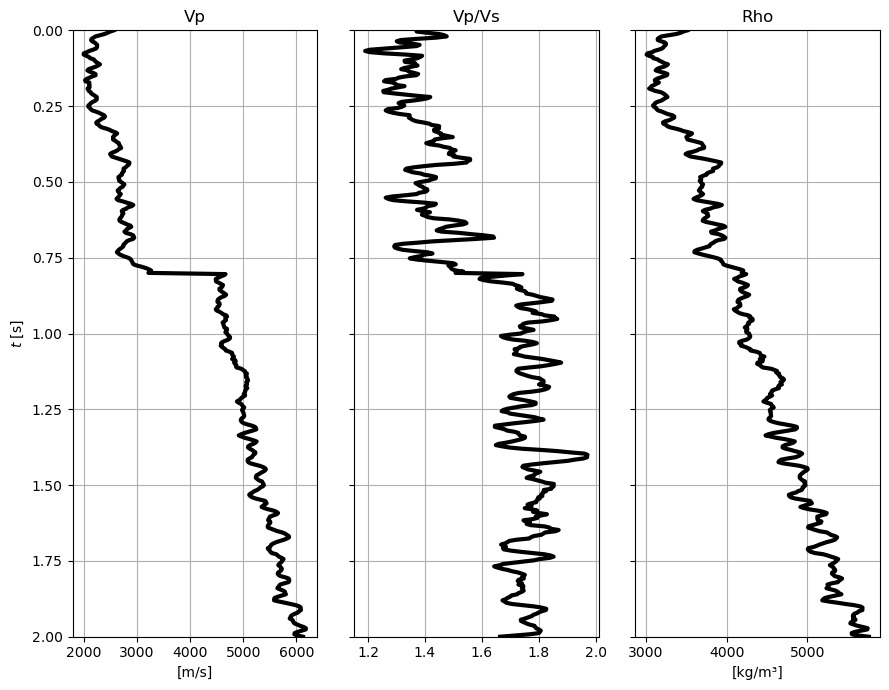

In [2]:
nt0 = 501
dt0 = 0.004
ntheta = 21

t0 = np.arange(nt0) * dt0
thetamin, thetamax = 0, 40
theta = np.linspace(thetamin, thetamax, ntheta)

# Elastic property profiles
vp = (
    2000
    + 5 * np.arange(nt0)
    + 2 * filtfilt(np.ones(5) / 5.0, 1, np.random.normal(0, 160, nt0))
)
vs = 600 + vp / 2 + 3 * filtfilt(np.ones(5) / 5.0, 1, np.random.normal(0, 100, nt0))
rho = 1000 + vp + filtfilt(np.ones(5) / 5.0, 1, np.random.normal(0, 120, nt0))
vp[201:] += 1500
vs[201:] += 500
rho[201:] += 100

# Wavelet
ntwav = 41
wavoff = 10
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 20)
wav_phase = np.hstack((wav[wavoff:], np.zeros(wavoff)))

# vs/vp profile
vsvp = vs / vp

# Model
m = np.stack((np.log(vp), np.log(vs), np.log(rho)), axis=1)

fig, axs = plt.subplots(1, 3, figsize=(9, 7), sharey=True)
axs[0].plot(vp, t0, "k", lw=3)
axs[0].set(xlabel="[m/s]", ylabel=r"$t$ [s]", ylim=[t0[0], t0[-1]], title="Vp")
axs[0].grid()
axs[1].plot(vp / vs, t0, "k", lw=3)
axs[1].set(title="Vp/Vs")
axs[1].grid()
axs[2].plot(rho, t0, "k", lw=3)
axs[2].set(xlabel="[kg/m³]", title="Rho")
axs[2].invert_yaxis()
axs[2].grid()
plt.tight_layout()

We create now the operators to model a synthetic pre-stack seismic gather
with a zero-phase as well as a mixed phase wavelet.



In [3]:
# Create operators
Wavesop = pylops.avo.prestack.PrestackWaveletModelling(
    m, theta, nwav=ntwav, wavc=wavc, vsvp=vsvp, linearization="akirich"
)
Wavesop_phase = pylops.avo.prestack.PrestackWaveletModelling(
    m, theta, nwav=ntwav, wavc=wavc, vsvp=vsvp, linearization="akirich"
)

/home/dtrad/anaconda3/envs/pylops/lib/python3.11/site-packages/pylops/utils/signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


Let's apply those operators to the elastic model and create some synthetic data



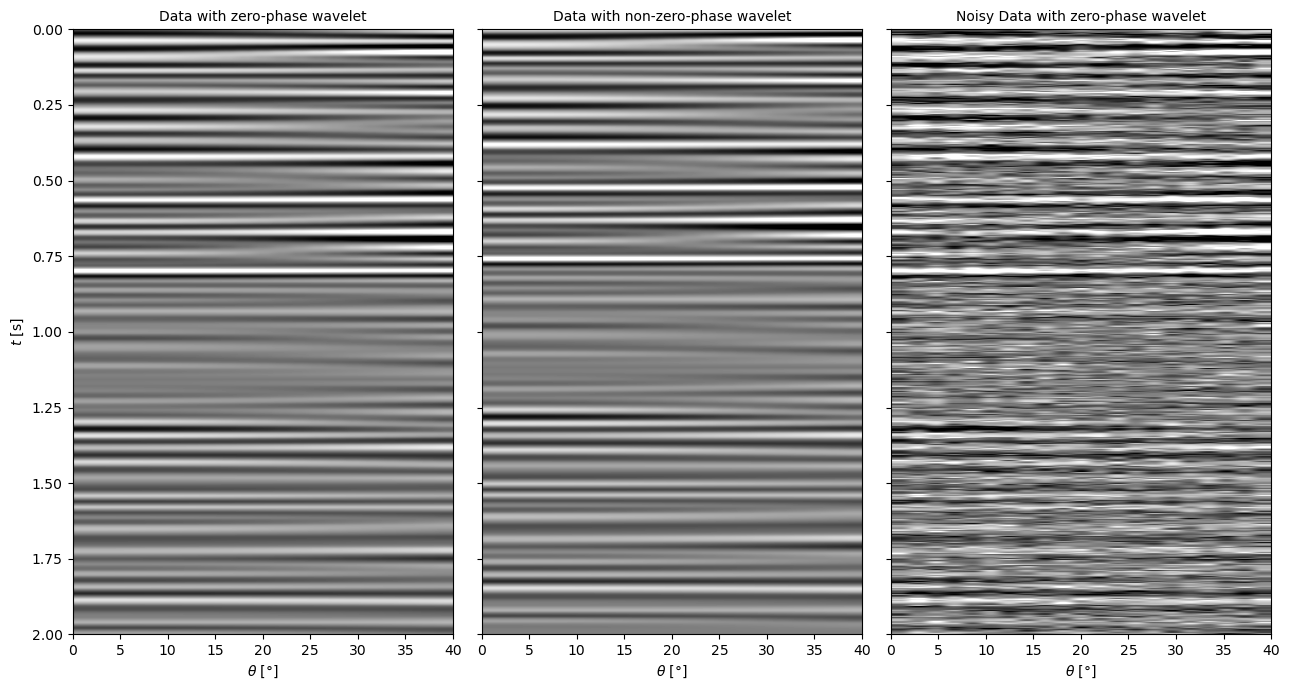

In [4]:
d = (Wavesop * wav).reshape(ntheta, nt0).T
d_phase = (Wavesop_phase * wav_phase).reshape(ntheta, nt0).T

# add noise
dn = d + np.random.normal(0, 3e-2, d.shape)

fig, axs = plt.subplots(1, 3, figsize=(13, 7), sharey=True)
axs[0].imshow(
    d, cmap="gray", extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1
)
axs[0].axis("tight")
axs[0].set(xlabel=r"$\theta$ [°]", ylabel=r"$t$ [s]")
axs[0].set_title("Data with zero-phase wavelet", fontsize=10)
axs[1].imshow(
    d_phase,
    cmap="gray",
    extent=(theta[0], theta[-1], t0[-1], t0[0]),
    vmin=-0.1,
    vmax=0.1,
)
axs[1].axis("tight")
axs[1].set_title("Data with non-zero-phase wavelet", fontsize=10)
axs[1].set_xlabel(r"$\theta$ [°]")
axs[2].imshow(
    dn, cmap="gray", extent=(theta[0], theta[-1], t0[-1], t0[0]), vmin=-0.1, vmax=0.1
)
axs[2].axis("tight")
axs[2].set_title("Noisy Data with zero-phase wavelet", fontsize=10)
axs[2].set_xlabel(r"$\theta$ [°]")
plt.tight_layout()

We can invert the data. First we will consider noise-free data, subsequently
we will add some noise and add a regularization terms in the inversion
process to obtain a well-behaved wavelet also under noise conditions.



In [5]:
wav_est = Wavesop / d.T.ravel()
wav_phase_est = Wavesop_phase / d_phase.T.ravel()
wavn_est = Wavesop / dn.T.ravel()

# Create regularization operator
D2op = pylops.SecondDerivative(ntwav, dtype="float64")

# Invert for wavelet
(
    wavn_reg_est,
    istop,
    itn,
    r1norm,
    r2norm,
) = pylops.optimization.leastsquares.regularized_inversion(
    Wavesop,
    dn.T.ravel(),
    [D2op],
    epsRs=[np.sqrt(0.1)],
    **dict(damp=np.sqrt(1e-4), iter_lim=200, show=0)
)

As expected, the regularization helps to retrieve a smooth wavelet
even under noisy conditions.



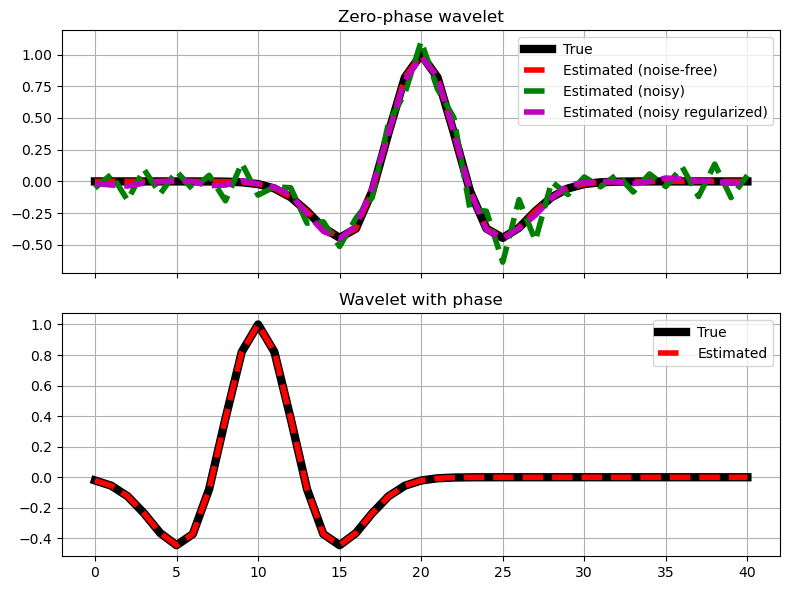

In [6]:
# sphinx_gallery_thumbnail_number = 3
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
axs[0].plot(wav, "k", lw=6, label="True")
axs[0].plot(wav_est, "--r", lw=4, label="Estimated (noise-free)")
axs[0].plot(wavn_est, "--g", lw=4, label="Estimated (noisy)")
axs[0].plot(wavn_reg_est, "--m", lw=4, label="Estimated (noisy regularized)")
axs[0].set_title("Zero-phase wavelet")
axs[0].grid()
axs[0].legend(loc="upper right")
axs[0].axis("tight")
axs[1].plot(wav_phase, "k", lw=6, label="True")
axs[1].plot(wav_phase_est, "--r", lw=4, label="Estimated")
axs[1].set_title("Wavelet with phase")
axs[1].grid()
axs[1].legend(loc="upper right")
axs[1].axis("tight")
plt.tight_layout()

Finally we repeat the same exercise, but this time we use a *preconditioner*.
Initially, our preconditioner is a :py:class:`pylops.Symmetrize` operator
to ensure that our estimated wavelet is zero-phase. After we chain
the :py:class:`pylops.Symmetrize` and the :py:class:`pylops.Smoothing1D`
operators to also guarantee a smooth wavelet.



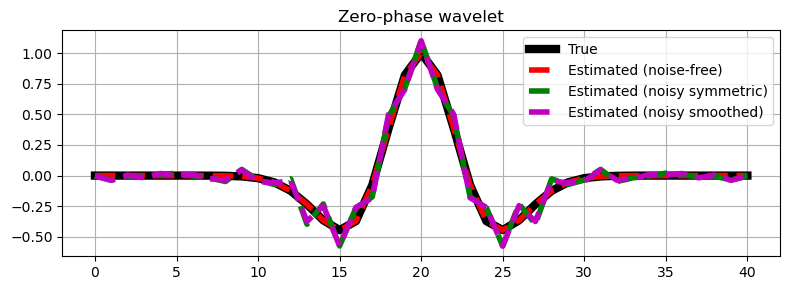

In [7]:
# Create symmetrize operator
Sop = pylops.Symmetrize((ntwav + 1) // 2)

# Create smoothing operator
Smop = pylops.Smoothing1D(5, dims=((ntwav + 1) // 2,), dtype="float64")

# Invert for wavelet
wavn_prec_est = pylops.optimization.leastsquares.preconditioned_inversion(
    Wavesop, dn.T.ravel(), Sop, **dict(damp=np.sqrt(1e-4), iter_lim=200, show=0)
)[0]

wavn_smooth_est = pylops.optimization.leastsquares.preconditioned_inversion(
    Wavesop, dn.T.ravel(), Sop * Smop, **dict(damp=np.sqrt(1e-4), iter_lim=200, show=0)
)[0]

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 3))
ax.plot(wav, "k", lw=6, label="True")
ax.plot(wav_est, "--r", lw=4, label="Estimated (noise-free)")
ax.plot(wavn_prec_est, "--g", lw=4, label="Estimated (noisy symmetric)")
ax.plot(wavn_smooth_est, "--m", lw=4, label="Estimated (noisy smoothed)")
ax.set_title("Zero-phase wavelet")
ax.grid()
ax.legend(loc="upper right")
plt.tight_layout()